In [239]:
import numpy as np
import networkx as nx
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import time
from copy import deepcopy

In [240]:
# -------------------------------------------
# 1. Modelo difuso para tráfico y retardos
# -------------------------------------------
hora = ctrl.Antecedent(np.arange(0, 24, 1), 'hora')
trafico = ctrl.Antecedent(np.arange(0, 101, 1), 'trafico')
dens_sem = ctrl.Antecedent(np.arange(0, 101, 1), 'dens_sem')
factor_vel = ctrl.Consequent(np.arange(0.5, 2.01, 0.01), 'factor_vel')
delay     = ctrl.Consequent(np.arange(0, 121,   1), 'delay')

# Membresías
hora['manana']   = fuzz.trimf(hora.universe, [5, 8,11])
hora['mediodia'] = fuzz.trimf(hora.universe, [11,13,15])
hora['tarde']    = fuzz.trimf(hora.universe, [15,18,21])
trafico['bajo']  = fuzz.trimf(trafico.universe, [0,10,30])
trafico['medio'] = fuzz.trimf(trafico.universe, [20,50,80])
trafico['alto']  = fuzz.trimf(trafico.universe, [60,90,100])
dens_sem['pocas']     = fuzz.trimf(dens_sem.universe, [0,10,30])
dens_sem['moderadas'] = fuzz.trimf(dens_sem.universe, [20,50,80])
dens_sem['muchas']    = fuzz.trimf(dens_sem.universe, [60,90,100])
factor_vel['lento']  = fuzz.trimf(factor_vel.universe, [0.5,0.75,1.0])
factor_vel['normal'] = fuzz.trimf(factor_vel.universe, [0.9,1.2,1.5])
factor_vel['rapido'] = fuzz.trimf(factor_vel.universe, [1.3,1.7,2.0])
delay['bajo']   = fuzz.trimf(delay.universe, [0,10,30])
delay['medio']  = fuzz.trimf(delay.universe, [20,40,60])
delay['alto']   = fuzz.trimf(delay.universe, [50,80,120])

# Reglas
rules = [
    ctrl.Rule(hora['manana']   & trafico['alto'],   factor_vel['lento']),
    ctrl.Rule(hora['mediodia'] & trafico['medio'],  factor_vel['normal']),
    ctrl.Rule(hora['tarde']    & trafico['bajo'],   factor_vel['rapido']),
    ctrl.Rule(dens_sem['muchas'],    delay['alto']),
    ctrl.Rule(dens_sem['moderadas'], delay['medio']),
    ctrl.Rule(dens_sem['pocas'],     delay['bajo'])
]

trafico_ctrl   = ctrl.ControlSystem(rules)
sim_factor_vel = ctrl.ControlSystemSimulation(trafico_ctrl)
sim_delay      = ctrl.ControlSystemSimulation(trafico_ctrl)


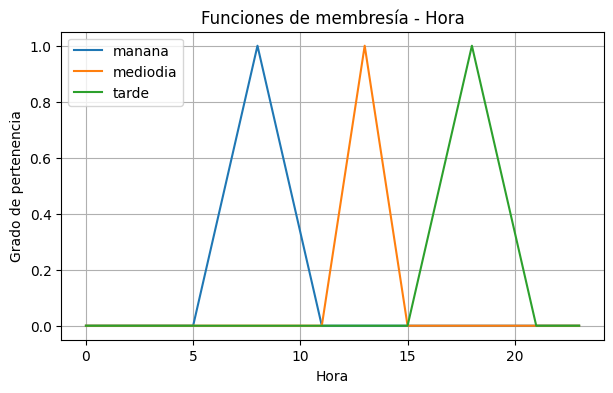

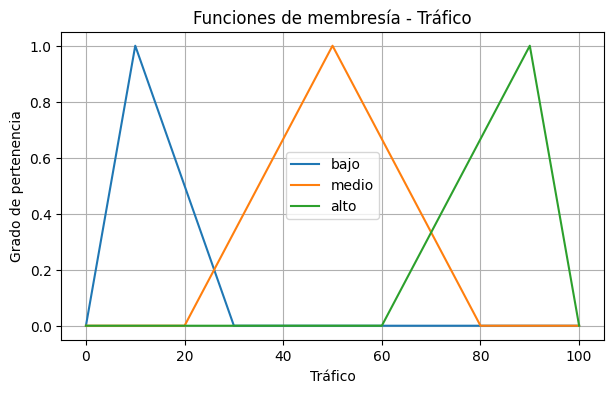

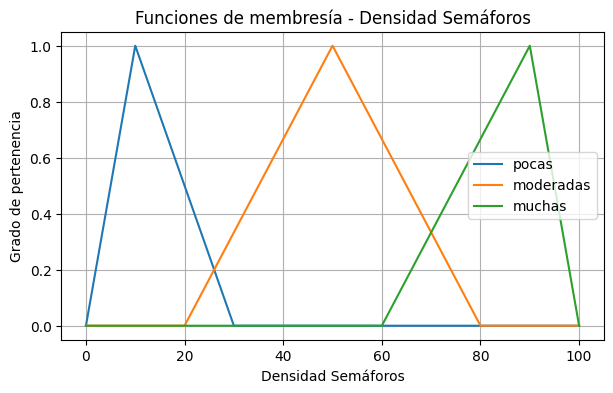

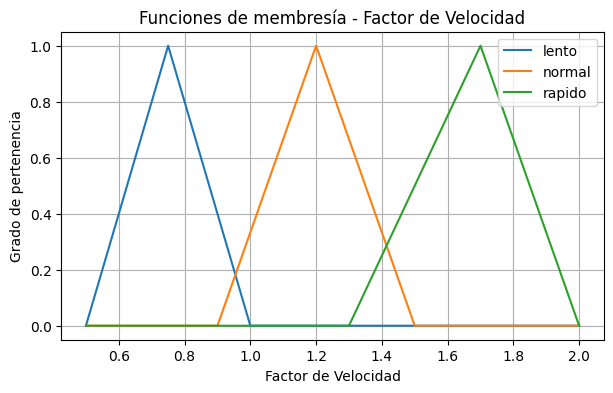

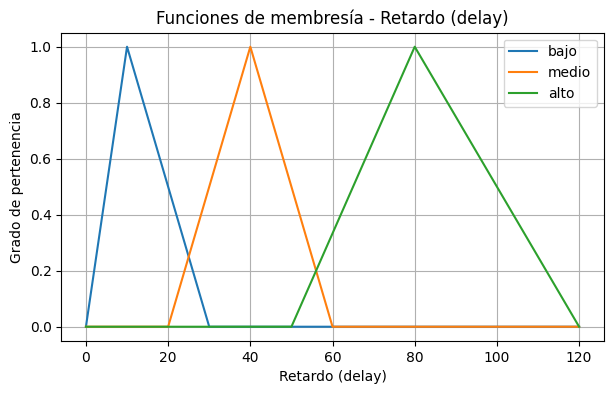

In [241]:
def plot_memberships(var, title):
    plt.figure(figsize=(7, 4))
    for term_name in var.terms:
        plt.plot(var.universe, var[term_name].mf, label=term_name)
    plt.title(f'Funciones de membresía - {title}')
    plt.xlabel(title)
    plt.ylabel('Grado de pertenencia')
    plt.legend()
    plt.grid(True)
    plt.show()

# Graficar cada variable
plot_memberships(hora, 'Hora')
plot_memberships(trafico, 'Tráfico')
plot_memberships(dens_sem, 'Densidad Semáforos')
plot_memberships(factor_vel, 'Factor de Velocidad')
plot_memberships(delay, 'Retardo (delay)')

In [242]:
for i, r in enumerate(rules):
    print(f"Regla {i+1}: SI {r.antecedent} ENTONCES {r.consequent}")


Regla 1: SI hora[manana] AND trafico[alto] ENTONCES [factor_vel[lento]]
Regla 2: SI hora[mediodia] AND trafico[medio] ENTONCES [factor_vel[normal]]
Regla 3: SI hora[tarde] AND trafico[bajo] ENTONCES [factor_vel[rapido]]
Regla 4: SI dens_sem[muchas] ENTONCES [delay[alto]]
Regla 5: SI dens_sem[moderadas] ENTONCES [delay[medio]]
Regla 6: SI dens_sem[pocas] ENTONCES [delay[bajo]]


In [243]:
# -------------------------------------------
# 2. Generador de instancias con depósito
# -------------------------------------------
class InstanceGenerator:
    def __init__(self, n_destinos, deposito, area_size=10):
        """
        n_destinos: número de nodos destino
        deposito: (x, y) del depósito, será nodo 0
        """
        self.n = n_destinos
        self.deposito = np.array(deposito)
        self.area = area_size

    def generate_coordinates(self):
        # Genera sólo destinos (nodos 1..n)
        return np.random.uniform(0, self.area, (self.n, 2))

    def build_dynamic_graph(self, coords):
        G = nx.DiGraph()
        # Nodo 0 = depósito
        G.add_node(0, coord=tuple(self.deposito), delay=0.0)
        # Nodos 1..n = destinos
        for i, (x, y) in enumerate(coords, start=1):
            G.add_node(i, coord=(x, y), delay=0.0)
        # Crear aristas
        for i in G.nodes:
            xi, yi = G.nodes[i]['coord']
            for j in G.nodes:
                if i == j: continue
                xj, yj = G.nodes[j]['coord']
                # Inferencia difusa
                h    = np.random.randint(0,24)
                traf = np.random.randint(0,101)
                dens = np.random.randint(0,101)
                sim_factor_vel.input['hora']    = h
                sim_factor_vel.input['trafico'] = traf
                sim_factor_vel.input['dens_sem']= dens
                sim_factor_vel.compute()
                alpha = sim_factor_vel.output.get('factor_vel',1.0)
                sim_delay.input['hora']    = h
                sim_delay.input['trafico'] = traf
                sim_delay.input['dens_sem']= dens
                sim_delay.compute()
                G.nodes[j]['delay'] = sim_delay.output.get('delay',0.0)
                # Distancia euclidiana base
                dist = np.hypot(xi-xj, yi-yj)
                t_ij = dist * alpha
                G.add_edge(i, j, time=t_ij)
        return G

## Funcion objetivo

In [244]:
# -------------------------------------------
# 3. Función de valoración mejorada
# -------------------------------------------
def route_cost(G, route, alpha=30.0, beta=1.0, gamma=5):
    """
    Cálculo de costo con:
     - D: distancia Manhattan total
     - Delta: suma delays
     - P: penalización giros
    """
    D = 0.0
    Delta = 0.0
    P = 0
    prev_dir = None

    for k in range(len(route)-1):
        i, j = route[k], route[k+1]
        x1, y1 = G.nodes[i]['coord']
        x2, y2 = G.nodes[j]['coord']
        # Distancia Manhattan
        d = abs(x1-x2) + abs(y1-y2)
        D += d
        # Delay (except depósito final)
        if j != 0:
            Delta += G.nodes[j]['delay']
        # Giro?
        curr_dir = 'h' if abs(x2-x1)>0 else 'v'
        if prev_dir is not None and curr_dir != prev_dir:
            P += 1
        prev_dir = curr_dir

    return alpha * D + beta * Delta + gamma * P

In [245]:
# ---------------------------
# 4. PSO con historial
# ---------------------------
class PSO_TSP:
    def __init__(
        self,
        G,
        swarm_size=60,
        w_max=0.9,
        w_min=0.4,
        c1=2.0,
        c2=2.0,
        max_iter=200,
        stall_limit=50,
        local_search_prob=0.2
    ):
        self.G = G
        self.nodes = [n for n in G.nodes if n != 0]
        self.swarm_size = swarm_size
        self.w_max, self.w_min = w_max, w_min
        self.c1, self.c2 = c1, c2
        self.max_iter = max_iter
        self.stall_limit = stall_limit
        self.local_search_prob = local_search_prob

        # Inicialización de partículas
        self.particles = [np.random.permutation(self.nodes).tolist() for _ in range(swarm_size)]
        self.pbest = deepcopy(self.particles)
        self.pbest_cost = [np.inf] * swarm_size
        self.gbest = None
        self.gbest_cost = np.inf

    def complete_route(self, perm):
        return [0] + perm + [0]

    def route_cost(self, route):
        return route_cost(self.G, route)

    def compute_swaps(self, a, b):
        swaps = []
        ac = a.copy()
        for i in range(len(ac)):
            if ac[i] != b[i]:
                j = ac.index(b[i])
                swaps.append((i, j))
                ac[i], ac[j] = ac[j], ac[i]
        return swaps

    def two_opt(self, route):
        # Mejora local 2-opt
        best = route
        best_cost = self.route_cost(best)
        improved = True
        while improved:
            improved = False
            for i in range(1, len(route)-2):
                for j in range(i+1, len(route)-1):
                    new_route = best[:i] + best[i:j+1][::-1] + best[j+1:]
                    cost = self.route_cost(new_route)
                    if cost < best_cost:
                        best, best_cost = new_route, cost
                        improved = True
                        break
                if improved:
                    break
        return best, best_cost

    def optimize(self, return_history=False):
        history = []
        no_improve = 0
        best_prev = np.inf

        for t in range(1, self.max_iter+1):
            # Inercia dinámica
            w = self.w_max - (self.w_max - self.w_min) * (t / self.max_iter)

            for idx in range(self.swarm_size):
                perm = self.particles[idx]

                # Calcular swaps hacia pbest y gbest
                swaps_p = self.compute_swaps(perm, self.pbest[idx])
                swaps_g = [] if self.gbest is None else self.compute_swaps(perm, self.gbest)

                # Número de swaps a usar
                n_p = int(self.c1 * np.random.rand() * len(swaps_p))
                n_g = int(self.c2 * np.random.rand() * len(swaps_g))
                n_w = int(w * (n_p + n_g))

                # Construir velocidad y aplicar
                vel = (swaps_p[:n_p] + swaps_g[:n_g])[:n_w]
                for i, j in vel:
                    perm[i], perm[j] = perm[j], perm[i]

                # Forma ruta completa y costo
                route = self.complete_route(perm)
                cost = self.route_cost(route)

                # Mejora local ocasional en pbest
                if np.random.rand() < self.local_search_prob:
                    route_ls, cost_ls = self.two_opt(route)
                    perm = route_ls[1:-1]
                    cost = cost_ls

                # Actualización pbest
                if cost < self.pbest_cost[idx]:
                    self.pbest_cost[idx] = cost
                    self.pbest[idx] = perm.copy()

                # Actualización gbest
                if cost < self.gbest_cost:
                    self.gbest_cost = cost
                    self.gbest = perm.copy()

            history.append(self.gbest_cost)

            # Early stopping
            if self.gbest_cost < best_prev - 1e-6:
                best_prev = self.gbest_cost
                no_improve = 0
            else:
                no_improve += 1
            if no_improve >= self.stall_limit:
                print(f"→ Parando temprano en iter {t} por no mejora en {self.stall_limit} iter.")
                break

        if return_history:
            return self.complete_route(self.gbest), self.gbest_cost, history
        return self.complete_route(self.gbest), self.gbest_cost


In [246]:
# ---------------------------
# 5. ABC con historial
# ---------------------------
class ABC_TSP:
    def __init__(
        self,
        G,
        num_bees=60,
        limit=50,
        max_iter=200,
        onlooker_ratio=0.5,
        scout_prob=0.1,
        local_search_prob=0.2
    ):
        self.G = G
        self.nodes = [n for n in G.nodes if n != 0]
        self.N = num_bees
        self.limit = limit
        self.max_iter = max_iter
        self.onlooker_ratio = onlooker_ratio
        self.num_onlookers = int(self.N * onlooker_ratio)
        self.scout_prob = scout_prob
        self.local_search_prob = local_search_prob

        # Inicialización
        self.sol = [np.random.permutation(self.nodes).tolist() for _ in range(self.N)]
        self.fit = [np.inf] * self.N
        self.trial = [0] * self.N
        self._evaluate_initial()

    def _evaluate_initial(self):
        for i in range(self.N):
            self.fit[i] = self.route_cost_perm(self.sol[i])

    def complete_route(self, perm):
        return [0] + perm + [0]

    def route_cost_perm(self, perm):
        return route_cost(self.G, self.complete_route(perm))

    def neighbor(self, perm):
        # swap or 2-opt neighbor
        if np.random.rand() < 0.5:
            a = perm.copy()
            i, j = np.random.choice(len(a), 2, replace=False)
            a[i], a[j] = a[j], a[i]
            return a
        else:
            # 2-opt
            i, j = sorted(np.random.choice(len(perm), 2, replace=False))
            new = perm.copy()
            new[i:j+1] = reversed(new[i:j+1])
            return new

    def optimize(self, return_history=False):
        history = []
        best_global = np.inf
        best_route = None

        for t in range(self.max_iter):
            # Phase Employed Bees
            for i in range(self.N):
                cand = self.neighbor(self.sol[i])
                fc = self.route_cost_perm(cand)
                if fc < self.fit[i]:
                    self.sol[i], self.fit[i] = cand, fc
                    self.trial[i] = 0
                else:
                    self.trial[i] += 1

                # local search on improvement
                if self.trial[i] == 0 and np.random.rand() < self.local_search_prob:
                    route_ls, cost_ls = self._two_opt(self.sol[i])
                    if cost_ls < self.fit[i]:
                        self.sol[i], self.fit[i] = route_ls[1:-1], cost_ls

            # Phase Onlooker Bees
            prob = (1 / (np.array(self.fit) + 1e-9))
            prob /= prob.sum()
            for _ in range(self.num_onlookers):
                i = np.random.choice(self.N, p=prob)
                cand = self.neighbor(self.sol[i])
                fc = self.route_cost_perm(cand)
                if fc < self.fit[i]:
                    self.sol[i], self.fit[i] = cand, fc
                    self.trial[i] = 0
                else:
                    self.trial[i] += 1

            # Phase Scout Bees
            for i in range(self.N):
                if self.trial[i] > self.limit or np.random.rand() < self.scout_prob:
                    self.sol[i] = np.random.permutation(self.nodes).tolist()
                    self.fit[i] = self.route_cost_perm(self.sol[i])
                    self.trial[i] = 0

            # Update global best and history
            idx_best = int(np.argmin(self.fit))
            if self.fit[idx_best] < best_global:
                best_global = self.fit[idx_best]
                best_route = self.complete_route(self.sol[idx_best])
            history.append(best_global)

        if return_history:
            return best_route, best_global, history
        return best_route, best_global

    def _two_opt(self, route):
        best = route
        best_cost = self.route_cost_perm(route)
        improved = True
        while improved:
            improved = False
            for i in range(1, len(best)-2):
                for j in range(i+1, len(best)-1):
                    new = best[:i] + best[i:j+1][::-1] + best[j+1:]
                    cost = self.route_cost_perm(new)
                    if cost < best_cost:
                        best, best_cost = new, cost
                        improved = True
                        break
                if improved:
                    break
        return best, best_cost

In [247]:
def make_animation(coords_map, route, deposito, pause=500):
    """
    Devuelve un FuncAnimation que muestra la ruta paso a paso.
    pause: tiempo por frame en milisegundos.
    """
    fig, ax = plt.subplots(figsize=(6,6))
    # Dibujamos los nodos fijos
    all_x = [coords_map[i][0] for i in coords_map]
    all_y = [coords_map[i][1] for i in coords_map]
    ax.scatter(all_x, all_y, c='black', s=20)
    ax.scatter(deposito[0], deposito[1], c='blue', marker='s', s=100)
    ax.text(deposito[0]+0.1, deposito[1]+0.1, '0',
            color='blue', fontsize=10, fontweight='bold')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel("X (km)")
    ax.set_ylabel("Y (km)")
    ax.set_title("Animación de ruta (Manhattan)")
    ax.grid(True)
    ax.set_aspect('equal','box')

    # Línea vacía que iremos actualizando
    line_h, = ax.plot([], [], c='green', lw=2)
    line_v, = ax.plot([], [], c='green', lw=2)
    texts = []

    def init():
        line_h.set_data([], [])
        line_v.set_data([], [])
        return line_h, line_v

    def animate(frame):
        # frame va de 0 a len(route)-2
        i = route[frame]
        j = route[frame+1]
        x1, y1 = coords_map[i]
        x2, y2 = coords_map[j]
        # horizontal primero
        line_h.set_data([x1, x2], [y1, y1])
        # vertical después
        line_v.set_data([x2, x2], [y1, y2])
        # Anotar el nodo i
        txt = ax.text(x1+0.1, y1+0.1, str(frame+1),
                      color='green', fontsize=8)
        texts.append(txt)
        return line_h, line_v, txt

    anim = animation.FuncAnimation(
        fig, animate,
        init_func=init,
        frames=len(route)-1,
        interval=pause,
        blit=True,
        repeat=False
    )
    return anim

In [248]:
# ---------------------------
# 6. Plot convergencia
# ---------------------------
def plot_convergence(history, label, color, destinos, deposito, limite):
    plt.plot(history, label=label, color=color)
    plt.xlabel("Iteración")
    plt.ylabel("Costo total")
    plt.title(f"Convergencia de la función de valoración para {destinos} destinos deposito en {deposito} y {limite} iteraciones")
    plt.grid(True)
    plt.legend()

In [ ]:
n_destinos_lista = [20, 50]
depositos = [[0,0], [5,5]]
n_limites_iteraciones = [100, 500]
lista_evaluaciones = []

for n in n_destinos_lista:
    for dep in depositos:
        gen = InstanceGenerator(n_destinos=n, deposito=dep)
        coords = gen.generate_coordinates()
        G = gen.build_dynamic_graph(coords)
        coords_map = {0:tuple(deposito)}
        for i,(x,y) in enumerate(coords, start=1):
            coords_map[i] = (x, y)
            
        for limite in n_limites_iteraciones:
            pso = PSO_TSP(G, max_iter = limite)
            inicio = time.perf_counter()
            ruta_pso, cost_pso, historial_pso = pso.optimize(return_history=True)
            fin = time.perf_counter()
            tiempo = fin - inicio
            aux = f"PSO - {limite} iteraciones - {n} destinos - deposito en {dep}"
            tipo = "PSO"
            costo = [cost_pso, tiempo]
            elemento = [aux,tipo, limite, n, dep, costo, historial_pso]
            lista_evaluaciones.append(elemento)
            
            abc = ABC_TSP(G, max_iter=limite)
            inicio = time.perf_counter()
            ruta_abc, cost_abc, historial_abc = abc.optimize(return_history=True)
            fin = time.perf_counter()
            tiempo = fin - inicio
            aux = f"ABC - {limite} iteraciones - {n} destinos - deposito en {dep}"
            tipo = "ABC"
            costo = [cost_abc, tiempo]
            elemento = [aux,tipo, limite, n, dep, costo, historial_abc]
            lista_evaluaciones.append(elemento)
            
            

→ Parando temprano en iter 55 por no mejora en 50 iter.
→ Parando temprano en iter 52 por no mejora en 50 iter.
→ Parando temprano en iter 51 por no mejora en 50 iter.
→ Parando temprano en iter 54 por no mejora en 50 iter.
→ Parando temprano en iter 56 por no mejora en 50 iter.


In [ ]:
PSO_20_dep0_l100 = []
PSO_20_dep0_l500 = []
PSO_20_dep5_l100 = []
PSO_20_dep5_l500 = []
PSO_50_dep0_l100 = []
PSO_50_dep0_l500 = []
PSO_50_dep5_l100 = []
PSO_50_dep5_l500 = []

ABC_20_dep0_l100 = []
ABC_20_dep0_l500 = []
ABC_20_dep5_l100 = []
ABC_20_dep5_l500 = []
ABC_50_dep0_l100 = []
ABC_50_dep0_l500 = []
ABC_50_dep5_l100 = []
ABC_50_dep5_l500 = []


"""
Iterativa que recorre todos los elemento de la lista y que va clasificando los datos segun el tipo de algoritmo (PSO/ABC), la cantidad de destinos, 
la ubicacion del deposito y el limite de iteraciones.
"""
for elemento in lista_evaluaciones:
    if elemento[1] == "PSO":
        if elemento[3] == 20:
            if elemento[4][0] == 0:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    PSO_20_dep0_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    PSO_20_dep0_l500.append(aux)
            else:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    PSO_20_dep5_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    PSO_20_dep5_l500.append(aux)
                    
        else:
            if elemento[4][0] == 0:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    PSO_50_dep0_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    PSO_50_dep0_l500.append(aux)
            else:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    PSO_50_dep5_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    PSO_50_dep5_l500.append(aux)
    else:
        if elemento[3] == 20:
            if elemento[4][0] == 0:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    ABC_20_dep0_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    ABC_20_dep0_l500.append(aux)
            else:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    ABC_20_dep5_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    ABC_20_dep5_l500.append(aux)
                    
        else:
            if elemento[4][0] == 0:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    ABC_50_dep0_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    ABC_50_dep0_l500.append(aux)
            else:
                if elemento[2] == 100:
                    aux = [elemento[5], elemento[6]]
                    ABC_50_dep5_l100.append(aux)
                else:
                    aux = [elemento[5], elemento[6]]
                    ABC_50_dep5_l500.append(aux)



## Comparación de ambos algoritmos

### 20 destinos, depósito en [0, 0] y 100 iteraciones

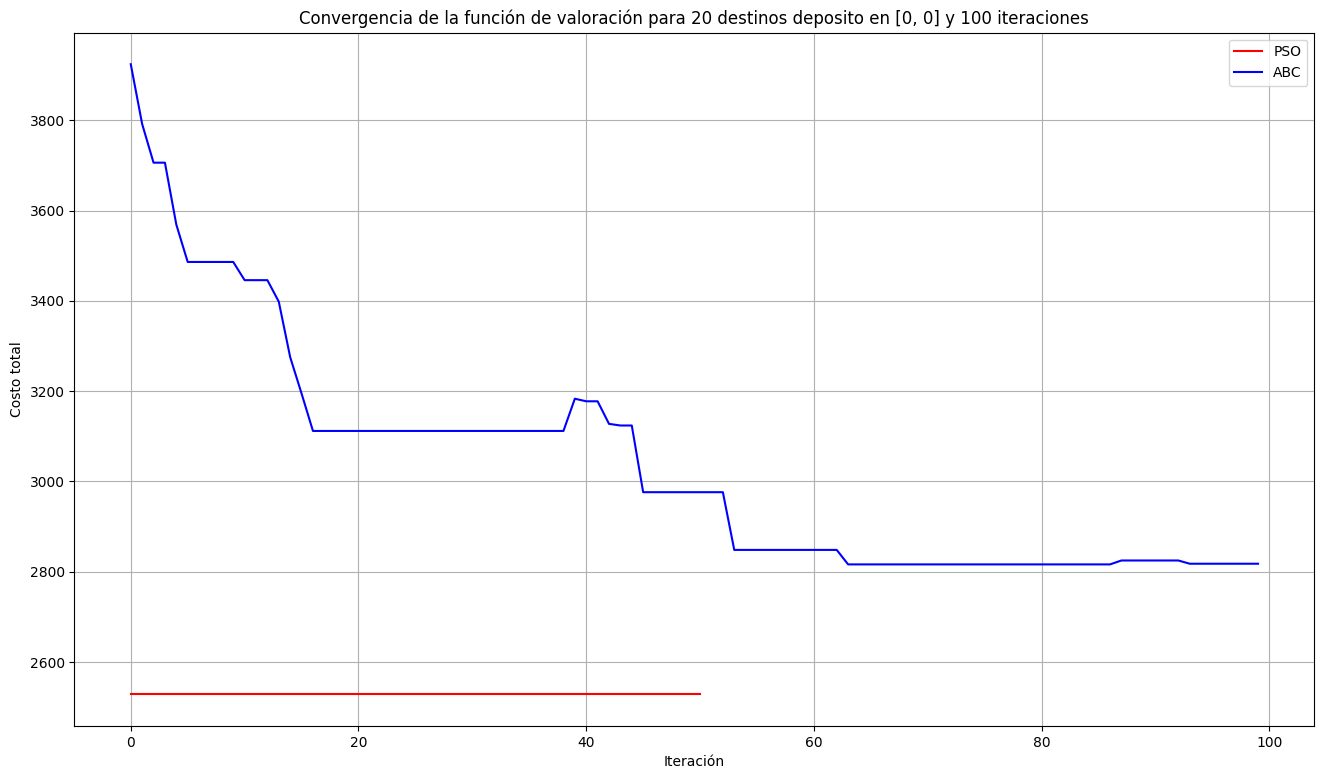

Tiempo de ejecucion para PSO: 1.2741764999991574 segundos
Costo para PSO: 42.141591892852816 minutos
Tiempo de ejecucion para ABC: 0.2899035840018769 segundos
Costo para ABC: 46.95957118459826 minutos


In [ ]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_20_dep0_l100[0][1], "PSO", "red",20,[0,0],100)
plot_convergence(ABC_20_dep0_l100[0][1], "ABC", "blue",20,[0,0],100)
plt.show()
print(f"Tiempo de ejecucion para PSO: {PSO_20_dep0_l100[0][0][1]} segundos")
print(f"Costo para PSO: {(PSO_20_dep0_l100[0][0][0]/60)} minutos")

print(f"Tiempo de ejecucion para ABC: {ABC_20_dep0_l100[0][0][1]} segundos")
print(f"Costo para ABC: {(ABC_20_dep0_l100[0][0][0])/60} minutos")

### 20 destinos, depósito en [0, 0] y 500 iteraciones

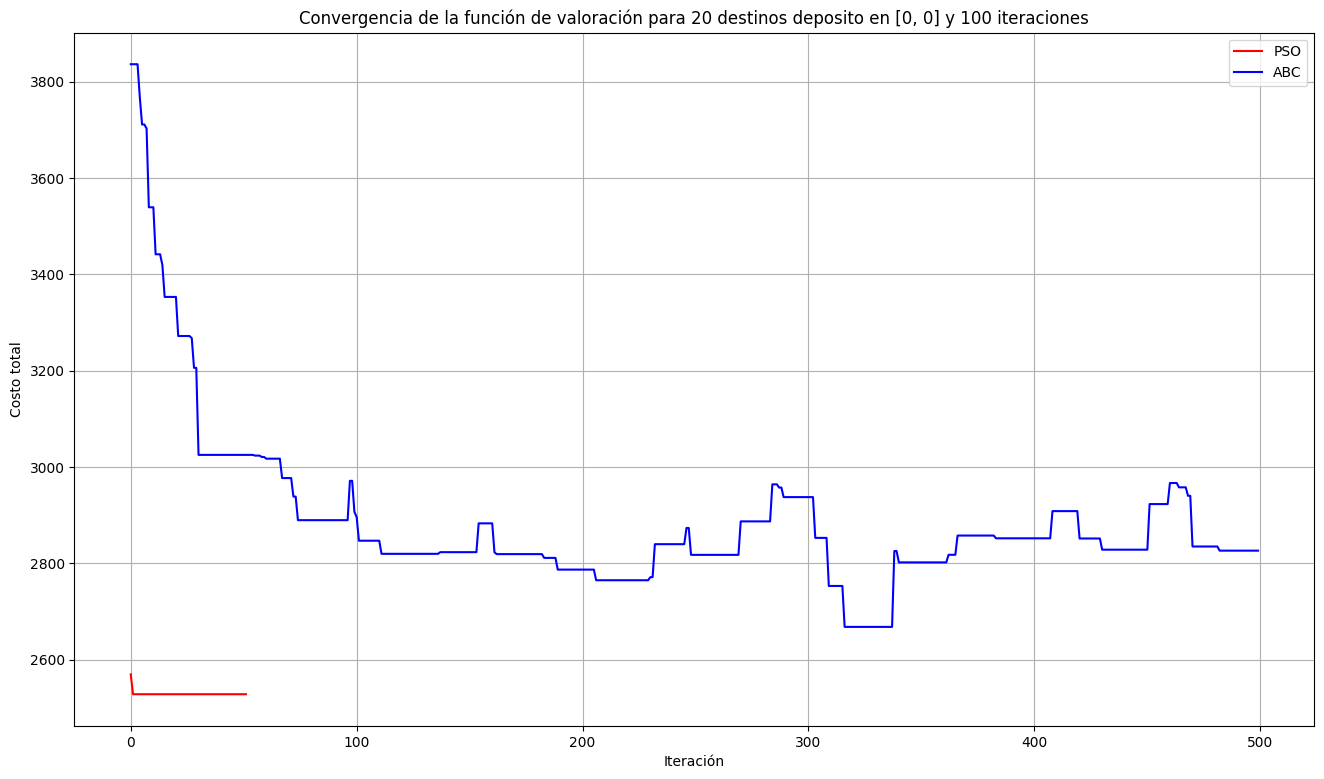

Tiempo de ejecucion para PSO: 1.4489687079985742 segundos
Costo para PSO: 42.141591892852816 minutos
Tiempo de ejecucion para ABC: 1.442756084001303 segundos
Costo para ABC: 47.10867165984532 minutos


In [ ]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_20_dep0_l500[0][1], "PSO", "red",20,[0,0],100)
plot_convergence(ABC_20_dep0_l500[0][1], "ABC", "blue",20,[0,0],100)
plt.show()

print(f"Tiempo de ejecucion para PSO: {PSO_20_dep0_l500[0][0][1]} segundos")
print(f"Costo para PSO: {(PSO_20_dep0_l500[0][0][0]/60)} minutos")

print(f"Tiempo de ejecucion para ABC: {ABC_20_dep0_l500[0][0][1]} segundos")
print(f"Costo para ABC: {(ABC_20_dep0_l500[0][0][0])/60} minutos")

### 20 destinos, depósito en [5, 5] y 100 iteraciones

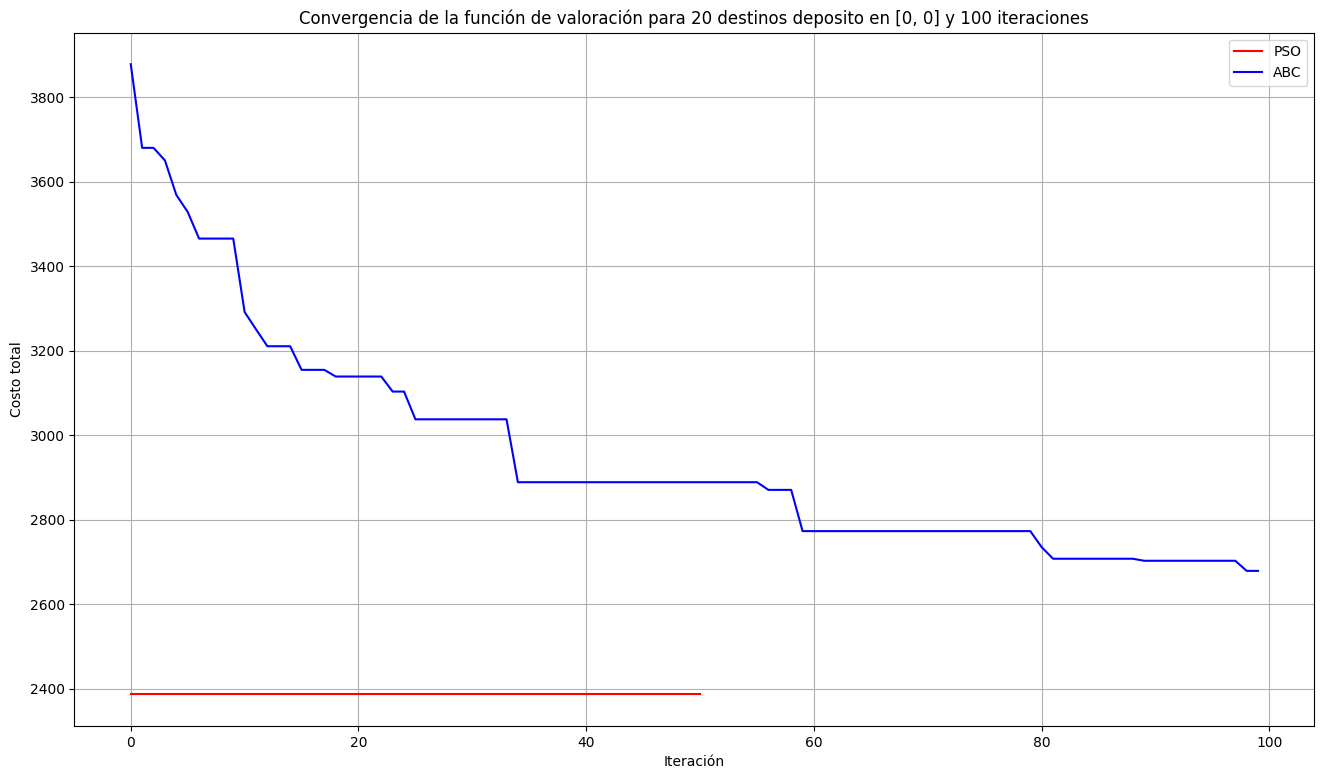

Tiempo de ejecucion para PSO: 0.9692367919997196 segundos
Costo para PSO: 39.77435349551177 minutos
Tiempo de ejecucion para ABC: 0.300791500001651 segundos
Costo para ABC: 44.64283120110182 minutos


In [ ]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_20_dep5_l100[0][1], "PSO", "red",20,[5,5],100)
plot_convergence(ABC_20_dep5_l100[0][1], "ABC", "blue",20,[0,0],100)
plt.show()

print(f"Tiempo de ejecucion para PSO: {PSO_20_dep5_l100[0][0][1]} segundos")
print(f"Costo para PSO: {(PSO_20_dep5_l100[0][0][0]/60)} minutos")

print(f"Tiempo de ejecucion para ABC: {ABC_20_dep5_l100[0][0][1]} segundos")
print(f"Costo para ABC: {(ABC_20_dep5_l100[0][0][0])/60} minutos")

### 20 destinos, depósito en [5, 5] y 500 iteraciones

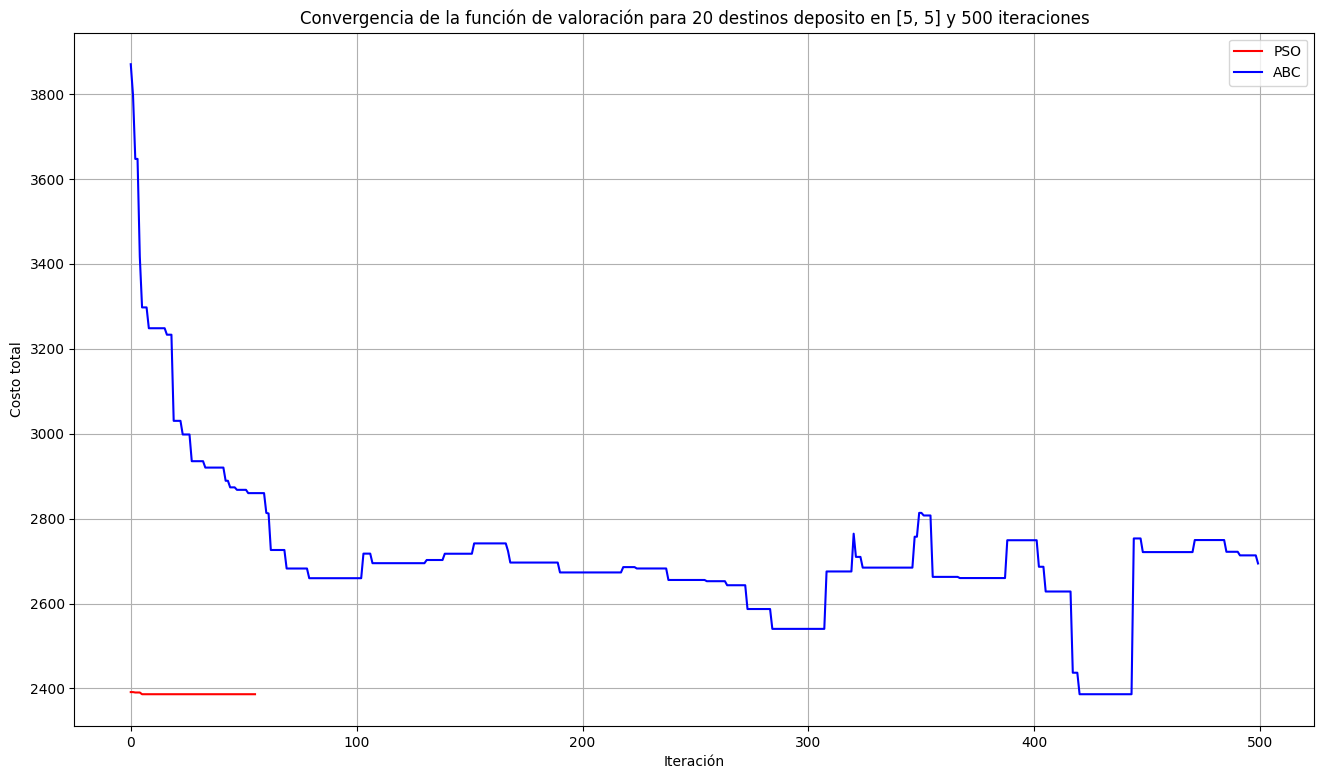

Tiempo de ejecucion para PSO: 1.7148135830029787 segundos
Costo para PSO: 39.77435349551177 minutos
Tiempo de ejecucion para ABC: 1.582410583003366 segundos
Costo para ABC: 44.90628911157502 minutos


In [ ]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_20_dep5_l500[0][1], "PSO", "red",20,[5,5],500)
plot_convergence(ABC_20_dep5_l500[0][1], "ABC", "blue",20,[5,5],500)
plt.show()

print(f"Tiempo de ejecucion para PSO: {PSO_20_dep5_l500[0][0][1]} segundos")
print(f"Costo para PSO: {(PSO_20_dep5_l500[0][0][0]/60)} minutos")

print(f"Tiempo de ejecucion para ABC: {ABC_20_dep5_l500[0][0][1]} segundos")
print(f"Costo para ABC: {(ABC_20_dep5_l500[0][0][0])/60} minutos")

### 50 destinos, depósito en [0, 0] y 100 iteraciones

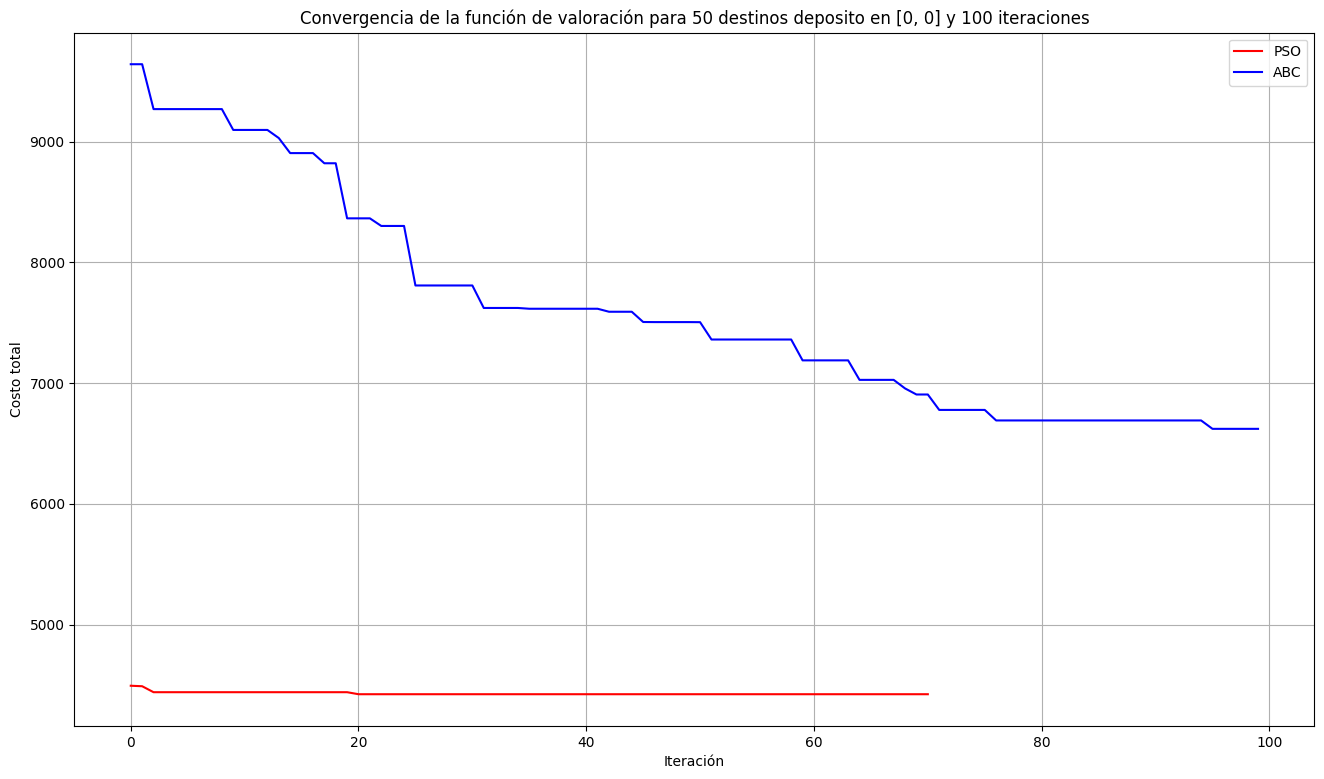

Tiempo de ejecucion para PSO: 72.39210008400187 segundos
Costo para PSO: 73.72924172155574 minutos
Tiempo de ejecucion para ABC: 0.592422916997748 segundos
Costo para ABC: 110.3522834645671 minutos


In [ ]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_50_dep0_l100[0][1], "PSO", "red",50,[0,0],100)
plot_convergence(ABC_50_dep0_l100[0][1], "ABC", "blue",50,[0,0],100)
plt.show()

print(f"Tiempo de ejecucion para PSO: {PSO_50_dep0_l100[0][0][1]} segundos")
print(f"Costo para PSO: {(PSO_50_dep0_l100[0][0][0]/60)} minutos")

print(f"Tiempo de ejecucion para ABC: {ABC_50_dep0_l100[0][0][1]} segundos")
print(f"Costo para ABC: {(ABC_50_dep0_l100[0][0][0])/60} minutos")

### 50 destinos, depósito en [0, 0] y 500 iteraciones

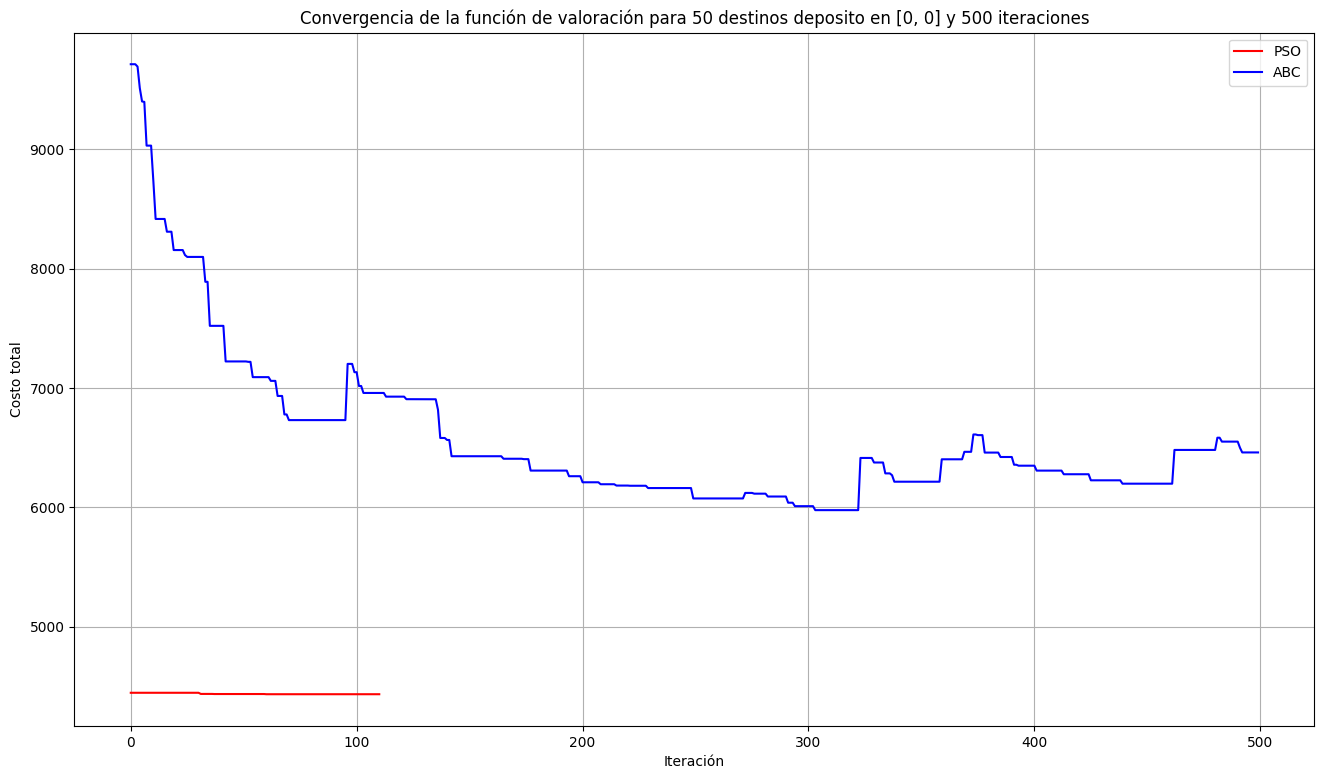

Tiempo de ejecucion para PSO: 103.73775199999727 segundos
Costo para PSO: 73.91094341616608 minutos
Tiempo de ejecucion para ABC: 2.805181875002745 segundos
Costo para ABC: 107.67039768968428 minutos


In [ ]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_50_dep0_l500[0][1], "PSO", "red",50,[0,0],500)
plot_convergence(ABC_50_dep0_l500[0][1], "ABC", "blue",50,[0,0],500)
plt.show()

print(f"Tiempo de ejecucion para PSO: {PSO_50_dep0_l500[0][0][1]} segundos")
print(f"Costo para PSO: {(PSO_50_dep0_l500[0][0][0]/60)} minutos")

print(f"Tiempo de ejecucion para ABC: {ABC_50_dep0_l500[0][0][1]} segundos")
print(f"Costo para ABC: {(ABC_50_dep0_l500[0][0][0])/60} minutos")

### 50 destinos, depósito en [5, 5] y 100 iteraciones

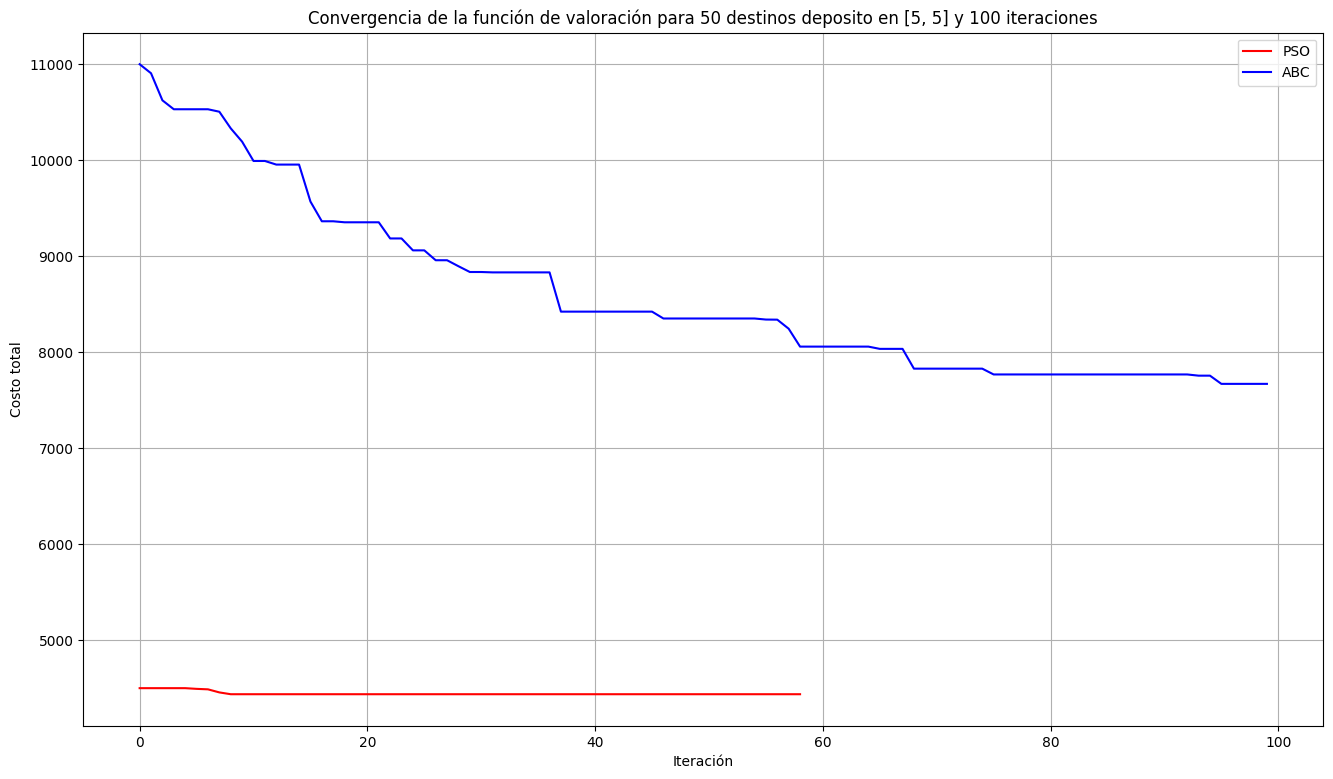

Tiempo de ejecucion para PSO: 62.348976542001765 segundos
Costo para PSO: 73.92709688582725 minutos
Tiempo de ejecucion para ABC: 0.5591871670003457 segundos
Costo para ABC: 127.80616830530815 minutos


In [ ]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_50_dep5_l100[0][1], "PSO", "red",50,[5,5],100)
plot_convergence(ABC_50_dep5_l100[0][1], "ABC", "blue",50,[5,5],100)
plt.show()

print(f"Tiempo de ejecucion para PSO: {PSO_50_dep5_l100[0][0][1]} segundos")
print(f"Costo para PSO: {(PSO_50_dep5_l100[0][0][0]/60)} minutos")

print(f"Tiempo de ejecucion para ABC: {ABC_50_dep5_l100[0][0][1]} segundos")
print(f"Costo para ABC: {(ABC_50_dep5_l100[0][0][0])/60} minutos")

### 50 destinos, depósito en [5, 5] y 500 iteraciones

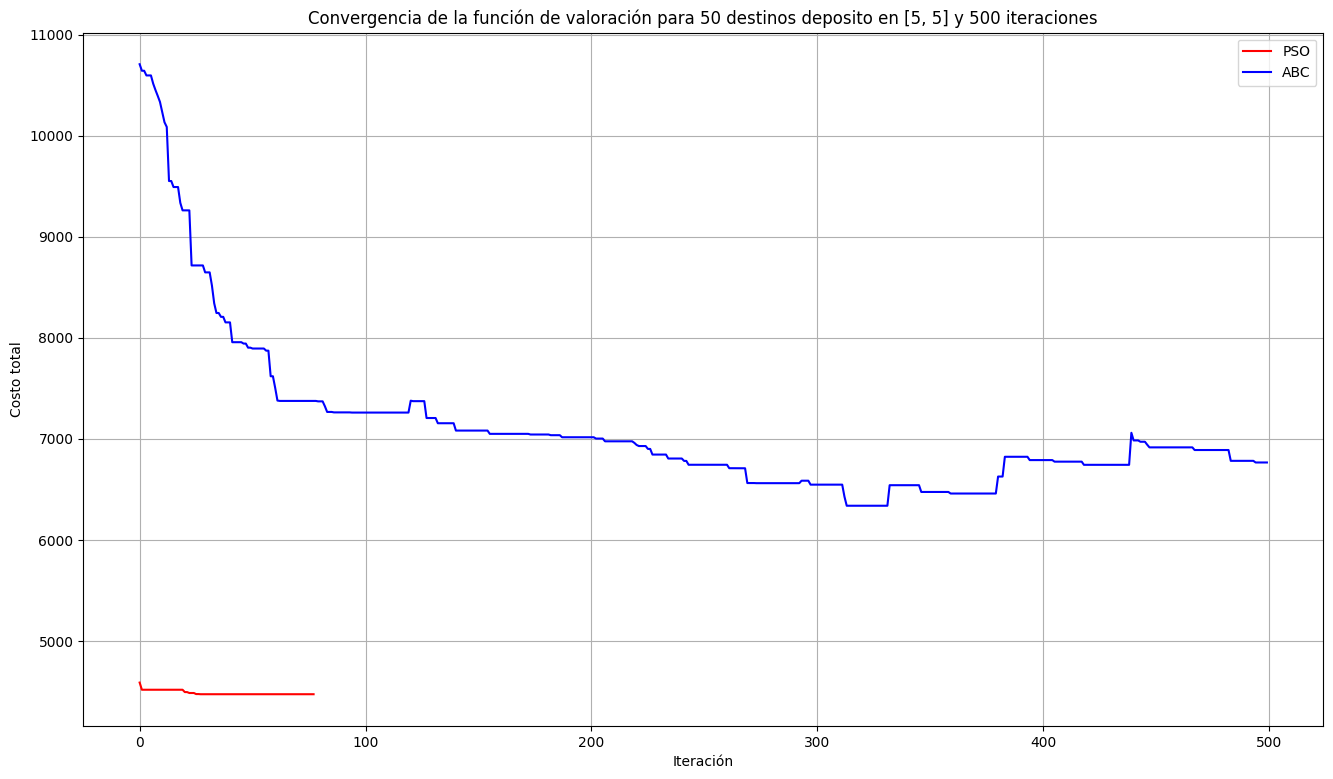

Tiempo de ejecucion para PSO: 45.26791579199926 segundos
Costo para PSO: 74.55788650111243 minutos
Tiempo de ejecucion para ABC: 2.772902584001713 segundos
Costo para ABC: 112.76865949693665 minutos


In [ ]:
plt.figure(figsize=(16,9))
plot_convergence(PSO_50_dep5_l500[0][1], "PSO", "red",50,[5,5],500)
plot_convergence(ABC_50_dep5_l500[0][1], "ABC", "blue",50,[5,5],500)
plt.show()

print(f"Tiempo de ejecucion para PSO: {PSO_50_dep5_l500[0][0][1]} segundos")
print(f"Costo para PSO: {(PSO_50_dep5_l500[0][0][0]/60)} minutos")

print(f"Tiempo de ejecucion para ABC: {ABC_50_dep5_l500[0][0][1]} segundos")
print(f"Costo para ABC: {(ABC_50_dep5_l500[0][0][0])/60} minutos")

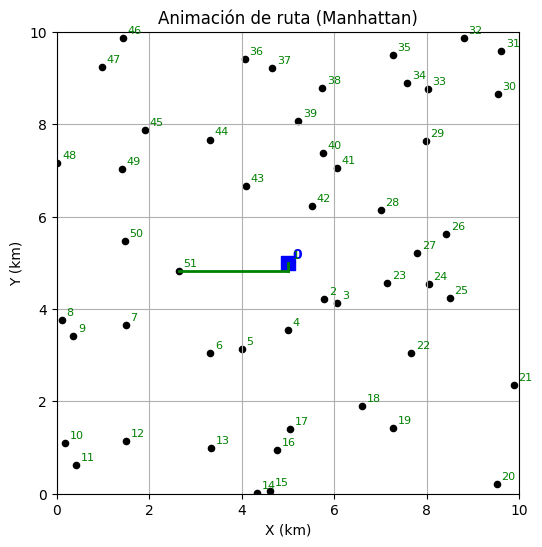

In [ ]:
anim = make_animation(coords_map, ruta_pso, deposito=[5,5], pause=500)# Animacion PSO
HTML(anim.to_jshtml())

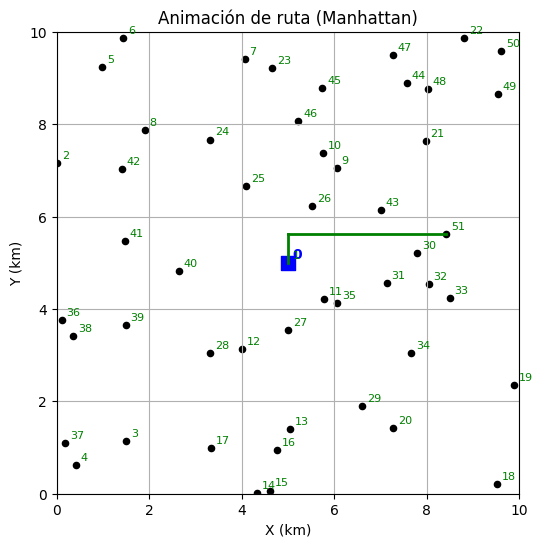

In [ ]:
anim2 = make_animation(coords_map, ruta_abc, deposito=[5,5], pause=500)
HTML(anim2.to_jshtml())